In [2]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures


# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

## Problem Statement

Pull at least 1,000 posts each from 2 subreddits forums (startups & startup_ideas) and build a classification model that identifies which subreddit each post came from with an accuracy score of at least 90%. 
    
The classification models that will be examine are: Logistic Regression, Decision Tree, Random Forest and Extra Trees. These will all be examine and we will select the best model to productionize.  

# Load Data

In [61]:
# Read in data.
df1 = pd.read_csv('../data/redditstartupclean_data.csv')

# Check out first five rows.
df1.head()

,title,subreddit,title_length,word_count,polarity
0,I might be in a pickle with regards to physica...,startups,64,12,0.000000
1,Is it possible to get a CTO to work on an app ...,startups,91,22,0.266667
2,Is it possible to get a CTO to work on an app ...,startups,91,22,0.266667
3,Is it possible to get a CTO to work on an app ...,startups,91,22,0.266667
4,Is it possible to get a CTO in the UK to work ...,startups,95,23,0.400000


In [62]:
df1.head()

,title,subreddit,title_length,word_count,polarity
0,I might be in a pickle with regards to physica...,startups,64,12,0.000000
1,Is it possible to get a CTO to work on an app ...,startups,91,22,0.266667
2,Is it possible to get a CTO to work on an app ...,startups,91,22,0.266667
3,Is it possible to get a CTO to work on an app ...,startups,91,22,0.266667
4,Is it possible to get a CTO in the UK to work ...,startups,95,23,0.400000


In [63]:
# Set startsup to 1 and startup_ideas to 0
df1['subreddit'] = df1['subreddit'].map({'startups': 1, 'Startup_Ideas': 0})

In [7]:
# Initialize X and y
X = df['title']
y = df['subreddit']

In [8]:
y.value_counts(normalize=True)

startups         0.5
Startup_Ideas    0.5
Name: subreddit, dtype: float64

# Set train/Test Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

# CountVectorizer

In [10]:
# Instantiate a CountVectorizer.
cvec = CountVectorizer()

# Fit the vectorizer on our corpus.
cvec.fit(X_train)

# Transform the corpus.
X_train_cv = cvec.transform(X_train)

X_test_cv = cvec.transform(X_test)

# Convert X_train, X_test into a DataFrame.
X_train_cv_df = pd.DataFrame(X_train_cv.todense(), 
                          columns=cvec.get_feature_names())

X_test_cv_df = pd.DataFrame(X_test_cv.todense(), 
                          columns=cvec.get_feature_names())

# Scale Data

In [11]:
ss = StandardScaler()

# ss.fit(X_train_df)
X_train_cv_sc = ss.fit_transform(X_train_cv_df)

X_test_cv_sc = ss.transform(X_test_cv_df)

# Expore LogisticRegression

In [12]:

lr = LogisticRegression()

lr.fit(X_train_cv_df, y_train)

lr.score(X_train_cv_df, y_train), lr.score(X_test_cv_df, y_test)

(0.9954166666666666, 0.9933333333333333)

In [17]:
# Scaled Data
lr = LogisticRegression()

lr.fit(X_train_cv_sc, y_train)

lr.score(X_train_cv_sc, y_train), lr.score(X_test_cv_sc, y_test)

(0.9954166666666666, 0.9933333333333333)

In [39]:
# Get predictions
preds = lr.predict(X_test_cv_df)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

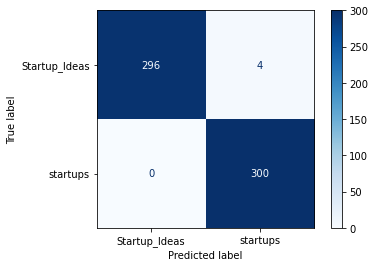

In [40]:
# View confusion matrix
plot_confusion_matrix(lr, X_test_cv_df, y_test, cmap='Blues', values_format='d');

In [41]:
# Calculate sensitivity / recall. pos % correct when actually true

sens =tp / (tp + fn)

print(f'Sensitivity: {round(sens, 4)}')

Sensitivity: 1.0


In [42]:
# Calculate specificity. % correct when actually false

spec = tn / (tn + fp)

print(f'Specificity: {round(spec, 4)}')

Specificity: 0.9867


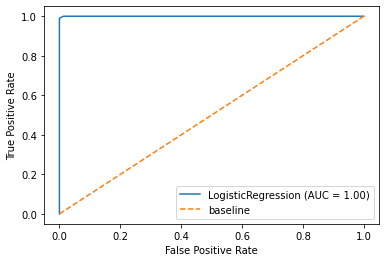

In [43]:
# Import metrics.
from sklearn import metrics

# ROC curve
metrics.plot_roc_curve(lr, X_test_cv_df, y_test)

# add worst case scenario line
plt.plot([0, 1], [0, 1], label = 'baseline', linestyle = '--')

# add a legend
plt.legend();

# Pipelines

CountVectorizer & MultinomialNB iteration 1

In [44]:
# Let's set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)

pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [45]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_params = {
    'cvec__max_features': [100, 300, 40, 500],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)]
}

In [46]:
# Instantiate GridSearchCV.

gs = GridSearchCV(pipe, # what object are we optimizing?
                  pipe_params, # what parameters values are we searching?
                  cv = 5) # 5-fold cross-validation.

In [47]:
# Fit GridSearch to training data.
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [100, 300, 40, 500],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)]})

In [48]:
# What's the best score?
gs.best_score_

0.8866666666666667

In [49]:
gs.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 500,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1)}

In [50]:
gs.score(X_train, y_train), gs.score(X_test, y_test)

(0.90625, 0.85)

In [51]:
# Get predictions
preds = gs.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

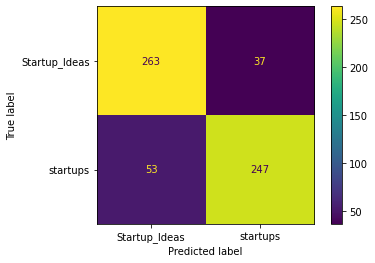

In [52]:
# View confusion matrix
plot_confusion_matrix(gs, X_test, y_test, cmap='viridis', values_format='d');

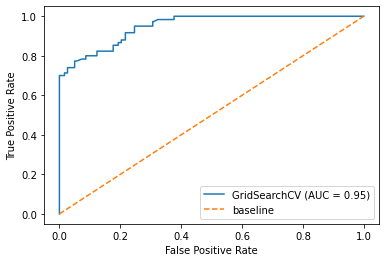

In [35]:
# Import metrics.
from sklearn import metrics

# ROC curve
metrics.plot_roc_curve(gs, X_test, y_test)

# add worst case scenario line
plt.plot([0, 1], [0, 1], label = 'baseline', linestyle = '--')

# add a legend
plt.legend();

Iteration II

In [53]:
pipe_params = {
    'cvec__max_features': [500, 1000, 2000, 3000],
    'cvec__min_df': [1, 2],
    'cvec__max_df': [.8, .9, .95],
    'cvec__ngram_range': [(1, 1), (1, 2)]
}

In [54]:
# Instantiate GridSearchCV.

gs = GridSearchCV(pipe, # what object are we optimizing?
                  pipe_params, # what parameters values are we searching?
                  cv = 5) # 5-fold cross-validation.

# Fit GridSearch to training data.
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.8, 0.9, 0.95],
                         'cvec__max_features': [500, 1000, 2000, 3000],
                         'cvec__min_df': [1, 2],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [55]:
(gs.best_score_)
(gs.best_params_)
gs.score(X_train_cv, y_train), gs.score(X_test_cv, y_test)

(0.9904166666666666, 0.9883333333333333)

# Random Forest

In [64]:
rf = RandomForestClassifier(random_state=42)

params = {
    'n_estimators': [75, 100, 150],
    'max_depth': [None],
    'max_features': ['auto', 'log2']
}
gs = GridSearchCV(rf, param_grid=params)
gs.fit(X_train_cv, y_train)
print(gs.best_score_) # cross val score!!
gs.best_params_

0.9954166666666667


{'max_depth': None, 'max_features': 'auto', 'n_estimators': 100}

In [66]:
gs.score(X_train_cv, y_train), gs.score(X_test_cv, y_test)

(0.9954166666666666, 0.9933333333333333)

In [68]:
# Get predictions
preds = gs.predict(X_test_cv)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

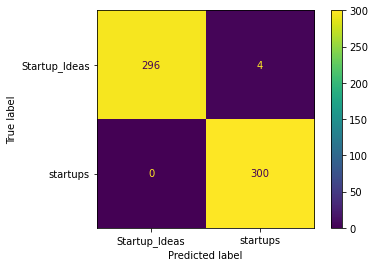

In [70]:
# View confusion matrix
plot_confusion_matrix(gs, X_test_cv, y_test, cmap='viridis', values_format='d');

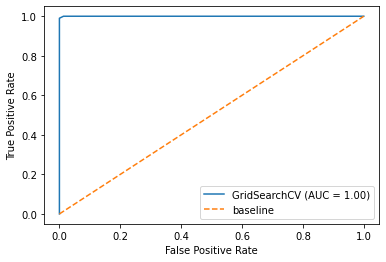

In [72]:
# Import metrics.
from sklearn import metrics

# ROC curve
metrics.plot_roc_curve(gs, X_test_cv, y_test)

# add worst case scenario line
plt.plot([0, 1], [0, 1], label = 'baseline', linestyle = '--')

# add a legend
plt.legend();

### Conclusions:
- No matter how great your model is it can not cater for all possible data sets as I am seeing 99% accuracy on my final dataset while I saw an 80% on the previous set of data.
- Although I got my desired results, I am unsure how my model will perform with another set of data
- My Production model will be a toss up between my Logistic Regression and Random Forest Model. Initially the Logistic Model was performing better but after changing the params they are both performing equally as well